In [1]:
%load_ext autoreload
%autoreload 2

import sys; 
sys.path.insert(0, '../../esinet')
sys.path.insert(0, '../')

import numpy as np
from copy import deepcopy
from scipy.sparse.csgraph import laplacian
from matplotlib import pyplot as plt
from scipy.spatial.distance import cdist
from scipy.stats import pearsonr
import mne
from esinet import Simulation
from esinet.forward import get_info, create_forward_model
from esinet.util import unpack_fwd
from invert.cmaps import parula
pp = dict(surface='white', hemi='both')

In [2]:
info = get_info(kind='biosemi64')
fwd = create_forward_model(info=info, sampling='ico3')

leadfield, pos = unpack_fwd(fwd)[1:3]
leadfield -= leadfield.mean(axis=0)
n_chans, n_dipoles = leadfield.shape
dist = cdist(pos, pos)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    6.6s remaining:    6.6s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    7.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    7.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.3s finished


Simulating data based on sparse patches.


100%|██████████| 2/2 [00:00<00:00, 87.19it/s]

Using control points [0.00000000e+00 0.00000000e+00 5.32221642e-08]


For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`
No projector specified for this dataset. Please consider the method self.add_proj.


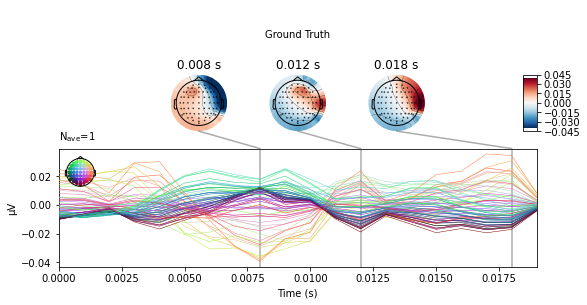

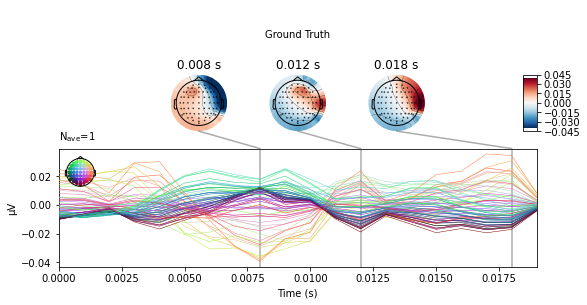

In [77]:
# settings = dict(number_of_sources=1, extents=40, duration_of_trial=0.01, target_snr=99999999999)
settings = dict(number_of_sources=6, extents=(1, 2), duration_of_trial=0.02, target_snr=1e99)

sim = Simulation(fwd, info, settings).simulate(2)
stc = sim.source_data[0]
evoked = sim.eeg_data[0].average()
y = evoked.data
x = stc.data
y -= y.mean(axis=0)

brain = stc.plot(**pp)
brain.add_text(0.1, 0.9, 'Ground Truth', 'title',
               font_size=14)
evoked.plot_joint(title="Ground Truth")

# Linearly Constrained minimum variance Beamformer

Using control points [1.51605191e-08 1.87573709e-08 6.52939869e-01]
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`
No projector specified for this dataset. Please consider the method self.add_proj.


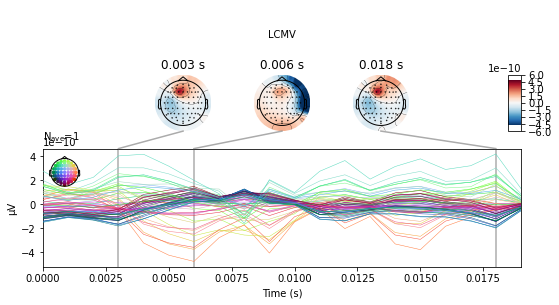

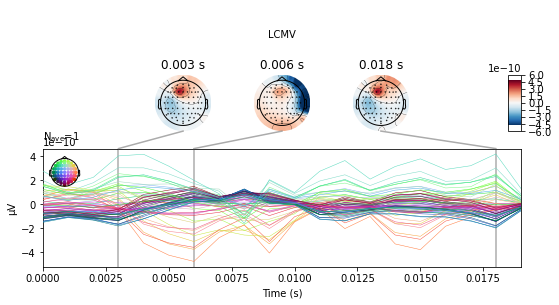

In [78]:
alpha = 0.0# * np.linalg.svd(leadfield)[1].max()
leadfield -= leadfield.mean(axis=0)
I = np.identity(n_chans)
C_inv = np.linalg.inv(y@y.T + alpha * I)
leadfield_norm = deepcopy(leadfield)
leadfield_norm -= leadfield_norm.mean(axis=0)
leadfield_norm /= np.linalg.norm(leadfield_norm, axis=0)

W = (C_inv @ leadfield) / np.diagonal(leadfield_norm.T @ C_inv @ leadfield_norm)

W = W / np.linalg.norm(W, axis=0)
inverse_operator = W.T
x_hat = inverse_operator@y
stc_ = stc.copy()
stc_.data = x_hat / x_hat.max()
stc_.plot(**pp, brain_kwargs=dict(title="LCMV"))

evoked_ = mne.EvokedArray(leadfield @ x_hat, evoked.info)
evoked_.plot_joint(title="LCMV")

# Weight-normalized minimum variance Beamformer

In [42]:
alpha = 0.0001 * np.linalg.svd(leadfield)[1].max()

leadfield_norm = deepcopy(leadfield)
leadfield_norm -= leadfield_norm.mean(axis=0)
leadfield_norm /= np.linalg.norm(leadfield_norm, axis=0)

I = np.identity(n_chans)
C_inv = np.linalg.inv(y@y.T + alpha * I)
C_inv_2 = np.linalg.inv(C_inv)

W = (C_inv @ leadfield_norm) / np.sqrt(abs(np.diagonal(leadfield_norm.T @ C_inv_2 @ leadfield_norm)))

W = W / np.linalg.norm(W, axis=0)
inverse_operator = W.T
x_hat = inverse_operator@y
stc_ = stc.copy()
stc_.data = x_hat
stc_.plot(**pp, brain_kwargs=dict(title="WNMV"))

Using control points [8.14752273e-06 9.34109387e-06 1.78907481e-05]
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`


Using control points [8.21618028e-06 8.72330426e-06 1.08569805e-05]


# Standardized minimum variance Beamformer

In [41]:
alpha = 0.3* np.linalg.svd(leadfield)[1].max()
leadfield_norm = deepcopy(leadfield)
leadfield_norm -= leadfield_norm.mean(axis=0)
leadfield_norm /= np.linalg.norm(leadfield_norm, axis=0)
I = np.identity(n_chans)
C_inv = np.linalg.inv(y@y.T + alpha * I)

W = (C_inv @ leadfield_norm) / abs(np.diagonal(np.sqrt(leadfield_norm.T @ C_inv @ leadfield_norm)))
W = W / np.linalg.norm(W, axis=0)
inverse_operator = W.T
x_hat = inverse_operator@y
stc_ = stc.copy()
stc_.data = x_hat
stc_.plot(**pp, brain_kwargs=dict(title="SMV"))

Using control points [8.14752284e-06 9.34109391e-06 1.78907482e-05]


C:\Users\Lukas\AppData\Local\Temp\ipykernel_12252\727463536.py:17: RuntimeWarning: invalid value encountered in sqrt
  W = (C_inv @ leadfield_norm) / abs(np.diagonal(np.sqrt(leadfield_norm.T @ C_inv @ leadfield_norm)))


For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`


Using control points [8.21618035e-06 8.72330433e-06 1.08569805e-05]
Using control points [8.21618035e-06 8.72330433e-06 1.08569805e-05]


# Higher-Order minimum variance Beamformer

In [45]:
alpha = 0.00 * np.linalg.svd(leadfield)[1].max()
n = 3
I = np.identity(n_chans)
C_inv = np.linalg.inv(y@y.T + alpha * I)
C_inv_n = deepcopy(C_inv)

for _ in range(n-1):
    C_inv_n = np.linalg.inv(C_inv_n)

W = (C_inv @ leadfield_norm) / np.sqrt(abs(np.diagonal(leadfield_norm.T @ C_inv_n @ leadfield_norm)))

W = W / np.linalg.norm(W, axis=0)
inverse_operator = W.T
x_hat = inverse_operator@y
stc_ = stc.copy()
stc_.data = x_hat
stc_.plot(**pp, brain_kwargs=dict(title="HOC-MV"))

Using control points [6.85345496e-23 8.38768841e-23 1.36582704e-18]
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`


# Eigenspace-based minimum variance Beamformer

In [58]:
from invert.util import find_corner
alpha = 0.00 * np.linalg.svd(leadfield)[1].max()
leadfield -= leadfield.mean(axis=0)
leadfield /= np.linalg.norm(leadfield, axis=0)

I = np.identity(n_chans)
C = y@y.T

U, s, _ = np.linalg.svd(C)
# j = find_corner(np.arange(len(s)), s)
j = np.where(((s**2)*len((s**2)) / (s**2).sum()) < np.exp(-16))[0][0]

Us = U[:, :j]
Un = U[:, j:]


C_inv = np.linalg.inv(C + alpha * I)

# W = []
# for i in range(n_dipoles):
#     l = leadfield[:, i][:, np.newaxis]
#     # w = np.linalg.inv(l.T @ C_inv @ l ) * l.T @ C_inv
#     w_mv = (C_inv @ l) / (l.T @ C_inv @ l)
#     w_esmv = Us @ Us.T @ w_mv
#     W.append(w_esmv)

# W = np.stack(W, axis=1)[:, :, 0]

W_mv = (C_inv @ leadfield) / np.diagonal(leadfield.T @ C_inv @ leadfield)

W = Us @ Us.T @ W_mv
# W = W / np.linalg.norm(W, axis=0)

inverse_operator = W.T
x_hat = inverse_operator@y
stc_ = stc.copy()
stc_.data = x_hat / x_hat.max()
stc_.plot(**pp, brain_kwargs=dict(title="EIGMV"))

Using control points [3.18462849e-14 5.95600341e-14 5.72635219e-01]
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`


# Multiple Constrained minimum variance Beamformer

In [65]:
L = deepcopy(leadfield)
L -= L.mean(axis=0)
L /= np.linalg.norm(L, axis=0)

alpha = 0.00 * np.linalg.svd(L)[1].max()

I = np.identity(n_chans)

C_inv = np.linalg.inv(y@y.T + alpha * I)

W = C_inv @ L * np.diagonal(np.linalg.inv(L.T @ C_inv @ L))

W /= np.linalg.norm(W, axis=0)

inverse_operator = W.T
x_hat = inverse_operator@y
stc_ = stc.copy()
stc_.data = x_hat / x_hat.max()
stc_.plot(**pp, brain_kwargs=dict(title="MCMV"))

Using control points [1.20956865e-08 1.54783064e-08 6.62487108e-01]
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`


Using control points [1.20518578e-08 1.43961068e-08 4.36957482e-01]


# Multiple Constrained Eigenspace MV Beamformer

In [66]:
from invert.util import find_corner
alpha = 0.00 * np.linalg.svd(leadfield)[1].max()

I = np.identity(n_chans)
C = y@y.T

U, s, _ = np.linalg.svd(C)
j = find_corner(np.arange(len(s)), s)

Us = U[:, :j]
Un = U[:, j:]


C_inv = np.linalg.inv(C + alpha * I)

W = []
for i in range(n_dipoles):
    l = leadfield[:, i][:, np.newaxis]
    # w = np.linalg.inv(l.T @ C_inv @ l ) * l.T @ C_inv
    w_mv = C_inv @ l *(1 / (l.T @ C_inv @ l))
    w_esmv = Us @ Us.T @ w_mv
    W.append(w_esmv)

W = np.stack(W, axis=1)[:, :, 0]
W = W / np.linalg.norm(W, axis=0)

inverse_operator = W.T
x_hat = inverse_operator@y
stc_ = stc.copy()
stc_.data = x_hat / x_hat.max()
stc_.plot(**pp, brain_kwargs=dict(title="EIG-MCMV"))

Using control points [1.96290334e-14 3.76967465e-14 3.49365706e-01]
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`


# ReciPSIICOS Projection

In [79]:
from invert.util import find_corner

G = deepcopy(leadfield)
G -= G.mean(axis=0)
G /= np.linalg.norm(G, axis=0)
# G_pwr = np.stack([g[:, np.newaxis] @ g[:, np.newaxis].T for g in G], axis=0)

# Prepare Data Covariance Matrix
I = np.identity(n_chans)
lam = 0.00
alpha = np.linalg.svd(y@y.T)[1].max()
C = y@y.T + lam * alpha * I

# Step 1
G_pwr = np.stack([g * g for g in G], axis=0)

# Step 2
U_pwr, S_pwr, V_pwr = np.linalg.svd(G_pwr, full_matrices=False)
k = find_corner(np.arange(len(S_pwr)), S_pwr)
print(k)
P = U_pwr[:, :k] @ U_pwr[:, :k].T

# Step 3
C_x = (P@C).T #np.stack([p*c for p, c in zip(P, C)], axis=0).T

# Step 4
E, A, _ = np.linalg.svd(C_x, full_matrices=False)
C_x = E @ np.diag(np.abs(A)) @ E.T
C_x_inv = np.linalg.inv(C_x)

# W = []
# for i in range(n_dipoles):
#     l = leadfield[:, i][:, np.newaxis]
#     w = np.linalg.inv(l.T @ C_x_inv @ l) @ l.T @ C_x_inv
#     W.append(w)
# W = np.stack(W, axis=1)[0].T
W = (C_x_inv @ G) * np.diagonal(np.linalg.inv(G.T @ C_x_inv @ G))
W /= np.linalg.norm(W, axis=0)
x_hat = W.T @ y

stc_ = stc.copy()
stc_.data = x_hat / x_hat.max()
stc_.plot(**pp, brain_kwargs=dict(title="ReciPSIICOS"))

12
Using control points [2.32127219e-08 2.80018125e-08 4.93796519e-01]
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`


# Eigenspace Beamformer

In [31]:
alpha = 0.001 * np.linalg.svd(leadfield)[1].max()
G = deepcopy(leadfield)
G -= G.mean(axis=0)
I = np.identity(n_chans)
C = y @ y.T
C_inv = np.linalg.inv(C + alpha * I)

W = []
for i in range(n_dipoles):
    g = leadfield[:, i][:, np.newaxis]
    Omega = np.linalg.inv(g.T @ C_inv @ g) @ g.T @ np.linalg.inv(C_inv) @ g @ np.linalg.inv(g.T @ C_inv @ g)
    w = (C_inv @ g @ np.linalg.inv(g.T @ C_inv @ g) ) / np.sqrt(Omega)
    W.append(w)
W = np.stack(W, axis=1)[:, :, 0]
W[np.isnan(W)] = 0

inverse_operator = W.T
x_hat = inverse_operator@y
stc_ = stc.copy()
stc_.data = x_hat / x_hat.max()
stc_.plot(**pp, brain_kwargs=dict(title="LCMV"))

Using control points [0.67677794 0.72169263 0.93420177]
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`


Using control points [0.64886661 0.66941376 0.75564227]
Using control points [0.64886661 0.66941376 0.75564227]
Using control points [0.24667187 0.25699729 0.29350401]


In [25]:
W.shape

(64, 1284)